In [1]:
import torch
from torch import nn
from read_data import read_data
from preproc import *
from dataloader import get_dls, Dataset
from model import Model,model_output
from training_loop import training_loop


In [13]:
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
from utils import f1score

In [2]:
training_sentence_tags = read_data('data/train.txt')
valid_sentence_tags = read_data('data/valid.txt')
vocabtoidx, labeltoidx = vocab_to_idx(training_sentence_tags)
dataset_train = Dataset(list(prepare_batch(training_sentence_tags, vocabtoidx, labeltoidx)))
dataset_valid = Dataset(list(prepare_batch(valid_sentence_tags, vocabtoidx, labeltoidx)))

### Ablation Studies

#### Batch Size

In [12]:
f1_scores=[]
for bs in [16,32,64,128,256,512]:
    train_dl = get_dls(dataset_train, bs)
    valid_dl = get_dls(dataset_valid, bs)
    net = Model(len(vocabtoidx), len(labeltoidx), 50, 50).to("cuda")
    loss_func = nn.CrossEntropyLoss()
    opt = torch.optim.SGD(net.parameters(),lr=1e1)
    training_loop(net, opt, loss_func, 5, train_dl, valid_dl,0)
    correct,predicted=model_output(net,valid_dl)
    f1_scores.append(f1score(correct.cpu(),predicted.cpu()))
    print(f1_scores[-1])
    

0.917943149649048
0.9067165626090666
0.8902741691550006
0.8609376817776399
0.8467057044247102
0.8176212820413387


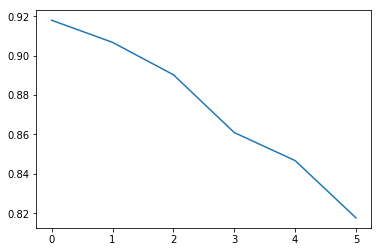

In [14]:
plt.plot(f1_scores)

#### Hidden Size

In [16]:
f1_scores=[]
for hs in [16,32,64,128,256,512]:
    train_dl = get_dls(dataset_train, 16)
    valid_dl = get_dls(dataset_valid, 16)
    net = Model(len(vocabtoidx), len(labeltoidx), 50, hs).to("cuda")
    loss_func = nn.CrossEntropyLoss()
    opt = torch.optim.SGD(net.parameters(),lr=1e1)
    training_loop(net, opt, loss_func, 5, train_dl, valid_dl,0)
    correct,predicted=model_output(net,valid_dl)
    f1_scores.append(f1score(correct.cpu(),predicted.cpu()))
    print(f1_scores[-1])

0.8919028968084693
0.9126885640051189
0.9163144219955792
0.9220149687827199
0.8981075735835886
0.884670570442471


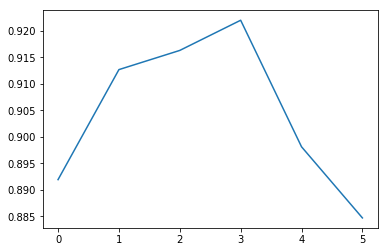

In [17]:
plt.plot(f1_scores)

#### Embedding size

In [18]:
f1_scores=[]
for es in [16,32,64,128,256,512]:
    train_dl = get_dls(dataset_train, 16)
    valid_dl = get_dls(dataset_valid, 16)
    net = Model(len(vocabtoidx), len(labeltoidx), es, 128).to("cuda")
    loss_func = nn.CrossEntropyLoss()
    opt = torch.optim.SGD(net.parameters(),lr=1e1)
    training_loop(net, opt, loss_func, 5, train_dl, valid_dl,0)
    correct,predicted=model_output(net,valid_dl)
    f1_scores.append(f1score(correct.cpu(),predicted.cpu()))
    print(f1_scores[-1])

0.8862799084810176
0.8813937255206111
0.9144530189630434
0.9307984643424981
0.9311474774110986
0.9308178539574204


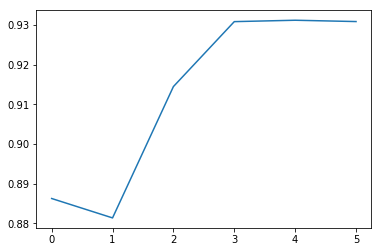

In [22]:
plt.plot(f1_scores)

In [19]:
from utils import classificationreport

In [21]:
print(classificationreport(correct.cpu(),predicted.cpu()))

             precision    recall  f1-score   support

          1       0.95      0.99      0.97     42973
          2       0.80      0.60      0.69      1340
          3       0.83      0.70      0.76       922
          4       0.89      0.57      0.70      1842
          5       0.77      0.59      0.67      1307
          6       0.80      0.80      0.80      1837
          7       0.65      0.56      0.60       750
          8       0.85      0.58      0.69       346
          9       0.76      0.71      0.73       257

avg / total       0.93      0.93      0.93     51574



#### Word embeddings

In [68]:
## code taken from fasttext library. It is a publicly available library.
import io

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        if tokens[0] in vocabtoidx or tokens[0]=='UNK':
            data[tokens[0]] = list(map(float, tokens[1:]))
    return data

In [70]:
word_vecs=load_vectors('data/wiki-news-300d-1M.vec')
matrix_len = len(vocabtoidx)+1
weights_matrix = torch.zeros((matrix_len, 300))
words_not_found = 0

for word,idx in vocabtoidx.items():
    try: 
        weights_matrix[idx] = torch.tensor((word_vecs[word]))
    except KeyError:
        weights_matrix[idx] = torch.tensor((word_vecs['UNK']))
        words_not_found+=1

In [109]:
weights_matrix.shape

torch.Size([23627, 300])

In [92]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Model1(nn.Module):
    def __init__(self, vocab_size, n_tags, emb_size, lstm_hidden_size,freeze=False):
        super(Model1, self).__init__()
        self.emb = nn.Embedding(vocab_size + 1, emb_size)
        self.emb=self.emb.from_pretrained(weights_matrix,freeze=freeze)
        self.lstm = nn.LSTM(emb_size, lstm_hidden_size, batch_first=True)
        self.linear = nn.Linear(lstm_hidden_size, n_tags)

    def forward(self, x):
        embed = self.emb(x)
        hidden, last = self.lstm(embed)
        hidden = hidden.contiguous().view(-1, hidden.shape[2])
        output = self.linear(hidden)
        return output

In [101]:
train_dl = get_dls(dataset_train, 16)
valid_dl = get_dls(dataset_valid, 16)
net = Model1(len(vocabtoidx), len(labeltoidx), 300, 128,freeze=True).to("cuda")
loss_func = nn.CrossEntropyLoss()
opt = torch.optim.SGD(net.parameters(),lr=1e-1)
training_loop(net, opt, loss_func, 15, train_dl, valid_dl,1)


0.47213031004879746 tensor(0.7643, device='cuda:0') 0.3566269246938591 tensor(0.8017, device='cuda:0')
0.3004857396335205 tensor(0.8123, device='cuda:0') 0.2691948675992577 tensor(0.8279, device='cuda:0')
0.23455574734806378 tensor(0.8605, device='cuda:0') 0.23320585490989795 tensor(0.8688, device='cuda:0')
0.20098688314482968 tensor(0.8908, device='cuda:0') 0.20181587077505578 tensor(0.8843, device='cuda:0')
0.1672391008999171 tensor(0.9056, device='cuda:0') 0.17060549934888217 tensor(0.8990, device='cuda:0')
0.13843111938766126 tensor(0.9174, device='cuda:0') 0.14878331785721163 tensor(0.9092, device='cuda:0')
0.11844774573472833 tensor(0.9277, device='cuda:0') 0.133931391121399 tensor(0.9177, device='cuda:0')
0.10462913580095691 tensor(0.9346, device='cuda:0') 0.12322704849361274 tensor(0.9247, device='cuda:0')
0.09470006671665572 tensor(0.9401, device='cuda:0') 0.11520699273434377 tensor(0.9281, device='cuda:0')
0.08739755306941563 tensor(0.9444, device='cuda:0') 0.1089950328358032

In [102]:
correct,predicted=model_output(net,valid_dl)


In [103]:
print(classificationreport(correct.cpu(),predicted.cpu()))

             precision    recall  f1-score   support

          1       0.96      0.99      0.98     42973
          2       0.77      0.59      0.67      1340
          3       0.80      0.62      0.70       922
          4       0.88      0.76      0.82      1842
          5       0.93      0.79      0.86      1307
          6       0.88      0.77      0.82      1837
          7       0.63      0.59      0.61       750
          8       0.79      0.39      0.52       346
          9       0.75      0.31      0.44       257

avg / total       0.94      0.94      0.94     51574



#### Without pretrained Word embeddings for 15 epochs

In [105]:
train_dl = get_dls(dataset_train, 16)
valid_dl = get_dls(dataset_valid, 16)
net = Model(len(vocabtoidx), len(labeltoidx), 128, 128).to("cuda")
loss_func = nn.CrossEntropyLoss()
opt = torch.optim.SGD(net.parameters(),lr=1e1)
training_loop(net, opt, loss_func, 15, train_dl, valid_dl,1)

0.45454660439694833 tensor(0.8266, device='cuda:0') 0.2647690739705815 tensor(0.8592, device='cuda:0')
0.1533076078427226 tensor(0.9060, device='cuda:0') 0.2196309111995219 tensor(0.8594, device='cuda:0')
0.09113963114310418 tensor(0.9424, device='cuda:0') 0.24662484064663884 tensor(0.8712, device='cuda:0')
0.05863472948217588 tensor(0.9620, device='cuda:0') 0.20084511626872323 tensor(0.8967, device='cuda:0')
0.038769203172961855 tensor(0.9750, device='cuda:0') 0.20126299249128468 tensor(0.9097, device='cuda:0')
0.02688939495191322 tensor(0.9829, device='cuda:0') 0.2180174663491238 tensor(0.9091, device='cuda:0')
0.01941922131124208 tensor(0.9879, device='cuda:0') 0.22888958608422616 tensor(0.9101, device='cuda:0')
0.01448682625141276 tensor(0.9911, device='cuda:0') 0.2313921547554914 tensor(0.9091, device='cuda:0')
0.011503704287881566 tensor(0.9930, device='cuda:0') 0.2354787191556346 tensor(0.9121, device='cuda:0')
0.009581039378657692 tensor(0.9941, device='cuda:0') 0.2361928665868

In [108]:
train_dl = get_dls(dataset_train, 16)
valid_dl = get_dls(dataset_valid, 16)
net = Model(len(vocabtoidx), len(labeltoidx), 128, 128).to("cuda")
loss_func = nn.CrossEntropyLoss()
opt = torch.optim.SGD(net.parameters(),lr=1e1)
training_loop(net, opt, loss_func, 5, train_dl, valid_dl,1)
correct,predicted=model_output(net,valid_dl)


0.6307419842494734 tensor(0.8118, device='cuda:0') 0.28337491053040675 tensor(0.8341, device='cuda:0')
0.16861798085586396 tensor(0.8977, device='cuda:0') 0.20220721119044838 tensor(0.8754, device='cuda:0')
0.0987532914808992 tensor(0.9375, device='cuda:0') 0.1621527185165731 tensor(0.9084, device='cuda:0')
0.06254672289780254 tensor(0.9602, device='cuda:0') 0.16802198568161594 tensor(0.9195, device='cuda:0')
0.041919105675562486 tensor(0.9736, device='cuda:0') 0.18907541373512848 tensor(0.9210, device='cuda:0')
